### 1. Import dependecies

In [25]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional,Dict

### 2. Load data

In [26]:
df = pd.read_csv('../data/processed/countries_pca_4components.csv')
X = df[['PC1', 'PC2', 'PC3', 'PC4']].values

### 3. Helper functions

In [27]:
def pairwise_distances_sq(X: np.ndarray) -> np.ndarray:
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    D[D < 0] = 0
    return D

def Hbeta(D: np.ndarray, beta: float) -> Tuple[float, np.ndarray]:
    P = np.exp(-D * beta)
    P[D == 0] = 0
    sumP = np.sum(P)
    if sumP == 0:
        H = 0
        P = np.zeros_like(P)
    else:
        H = np.log(sumP) + beta * np.sum(D * P) / sumP
        P = P / sumP
    return H, P

def compute_P_matrix(X: np.ndarray, perplexity: float = 30.0) -> np.ndarray:
    print("Computing pairwise distances and P matrix...")
    n = X.shape[0]
    D = pairwise_distances_sq(X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    for i in range(n):
        if i % 50 == 0:
            print(f"Computing P-values for point {i} of {n}...")
        betamin = -np.inf
        betamax = np.inf
        Di = np.concatenate((D[i, :i], D[i, i + 1:]))
        H, thisP = Hbeta(Di, beta[i])
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > 1e-5 and tries < 50:
            if Hdiff > 0:
                betamin = beta[i].copy()
                beta[i] = beta[i] * 2 if betamax == np.inf else (beta[i] + betamax) / 2
            else:
                betamax = beta[i].copy()
                beta[i] = beta[i] / 2 if betamin == -np.inf else (beta[i] + betamin) / 2
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        P[i, np.concatenate((np.r_[0:i], np.r_[i + 1:n]))] = thisP

    P = (P + P.T) / (2 * n)
    P = np.maximum(P, 1e-12)
    print("Mean sigma:", np.mean(np.sqrt(1 / beta)))
    return P


### 4. t-SNE Implementation

In [28]:
def run_tsne(X: np.ndarray, perplexity=30, n_iter=1000, learning_rate=200) -> np.ndarray:
    n = X.shape[0]
    np.random.seed(42)

    P = compute_P_matrix(X, perplexity)
    P *= 12.0  # early exaggeration

    # Random initialization for Y
    Y = np.random.randn(n, 2) * 1e-4
    Y -= np.mean(Y, axis=0)

    dY = np.zeros_like(Y)
    iY = np.zeros_like(Y)
    gains = np.ones_like(Y)
    momentum = 0.5
    final_momentum = 0.8
    min_gain = 0.01

    for it in range(n_iter):
        D = pairwise_distances_sq(Y)
        num = 1 / (1 + D)
        np.fill_diagonal(num, 0)
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (2, 1)).T * (Y[i, :] - Y), axis=0)

        # Adaptive gains
        gains = (gains + 0.2) * ((dY > 0) != (iY > 0)) + (gains * 0.8) * ((dY > 0) == (iY > 0))
        gains[gains < min_gain] = min_gain

        curr_momentum = momentum if it < 250 else final_momentum
        iY = curr_momentum * iY - learning_rate * (gains * dY)
        Y += iY
        Y -= np.mean(Y, axis=0)

        if it == 100:
            P /= 12.0  # stop early exaggeration

        if (it + 1) % 100 == 0:
            C = np.sum(P * np.log(P / Q))
            print(f"Iteration {it + 1}/{n_iter} - error = {C:.6f}")

    print("t-SNE completed.")
    return Y

### 5. Run t-SNE & Save

In [ ]:
perplexity = 30
learning_rate = 100
iterations = 1000

Y = run_tsne(X, perplexity=perplexity, n_iter=iterations, learning_rate=learning_rate)

os.makedirs("../data/processed", exist_ok=True)
os.makedirs("../artifacts/figures", exist_ok=True)

tsne_df = pd.DataFrame(Y, columns=['tSNE_1', 'tSNE_2'])
tsne_df.to_csv("../data/processed/best_tsne_dataset.csv", index=False)
print("Best t-SNE dataset saved to '../data/processed/best_tsne_dataset.csv'")
tsne_df

Computing pairwise distances and P matrix...
Computing P-values for point 0 of 167...
Computing P-values for point 50 of 167...
Computing P-values for point 100 of 167...
Computing P-values for point 150 of 167...
Mean sigma: 1.7401137354764358
Iteration 100/1000 - error = 45.889196
Iteration 200/1000 - error = 0.224398
Iteration 300/1000 - error = 0.222063
Iteration 400/1000 - error = 0.222060
Iteration 500/1000 - error = 0.222060
Iteration 600/1000 - error = 0.222060
Iteration 700/1000 - error = 0.222060
Iteration 800/1000 - error = 0.222060
Iteration 900/1000 - error = 0.222060
Iteration 1000/1000 - error = 0.222060
t-SNE completed.
Best t-SNE dataset saved to '../data/processed/best_tsne_dataset.csv'


,tSNE_1,tSNE_2
0,10.040190,8.803448
1,-2.726991,-1.004057
2,-0.930138,3.537760
3,9.013713,11.506413
4,-3.281567,-4.976215
...,...,...
162,3.439313,1.945979
163,-1.400132,5.236438
164,0.179984,-3.779322
165,5.439371,8.195802


### 6. Plot & Save Figure

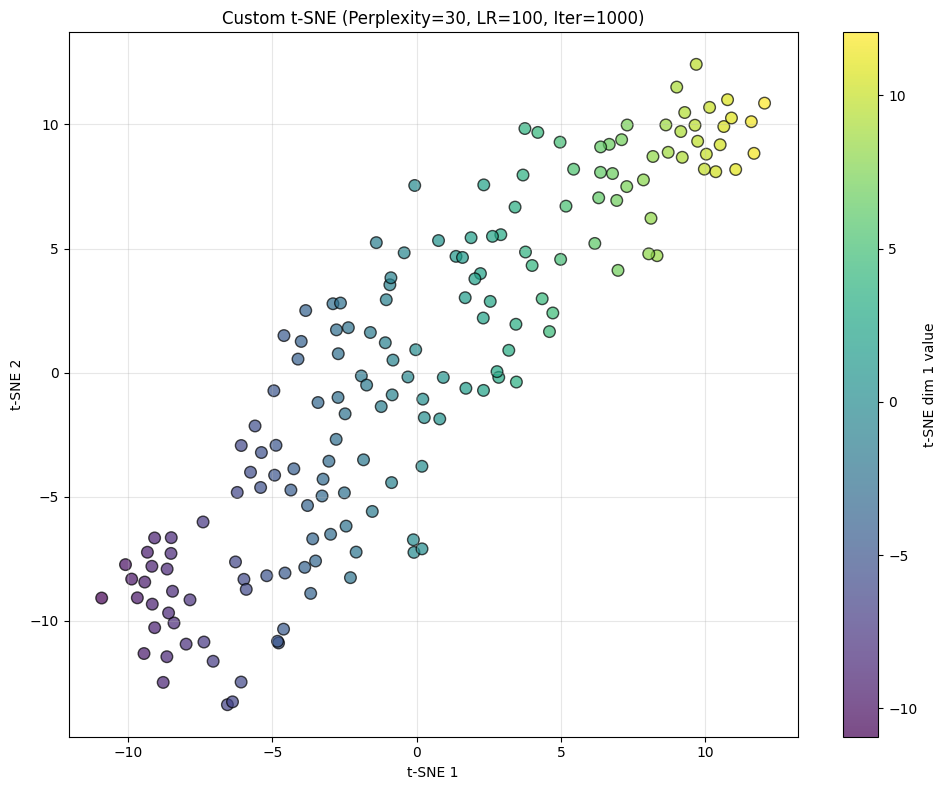

Figure saved to '../artifacts/figures/tsne5_clusters.png'


In [30]:
plt.figure(figsize=(10, 8))
plt.scatter(Y[:, 0], Y[:, 1], c=Y[:, 0], cmap='viridis', s=70, alpha=0.7, edgecolor='k')
plt.title(f"Custom t-SNE (Perplexity={perplexity}, LR={learning_rate}, Iter={iterations})")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True, alpha=0.3)
plt.colorbar(label='t-SNE dim 1 value')
plt.tight_layout()
plt.savefig("../artifacts/figures/tsne30_clusters.png", dpi=300)
plt.show()
print("Figure saved to '../artifacts/figures/tsne5_clusters.png'")